# Sample usage

This notebook gives you introduction to use the package.

In [1]:
import pathlib
import sys
sys.path.append("../")
sys.path.append(".")
from model_criticism_mmd import ModelTrainerTorchBackend, MMD, TwoSampleDataSet, split_data
from model_criticism_mmd.backends import kernels_torch
from model_criticism_mmd.models.static import DEFAULT_DEVICE

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas
import torch

In [3]:
N_EPOCHS = 300

# Device choice

If you are able to use CUDA, you can give `device_obj` to objects. The default value is CPU.

In [4]:
device_obj = DEFAULT_DEVICE

# Scenario-1: 2 distributions are similar

In [5]:
x = np.random.normal(3, 0.5, size=(500, 2))
y = np.random.normal(3, 0.5, size=(500, 2))

In [6]:
df_x = pandas.DataFrame(x)
df_x['label'] = 'green'
df_y = pandas.DataFrame(y)
df_y['label'] = 'red'
df_data_scenario_1 = pandas.concat([df_x, df_y])
df_data_scenario_1.columns = ['dim0', 'dim1', 'label']

<AxesSubplot:xlabel='dim0', ylabel='dim1'>

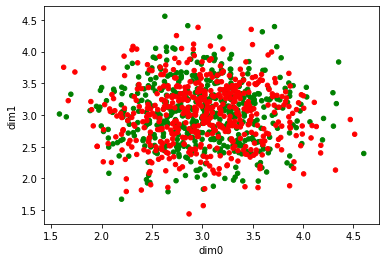

In [7]:
df_data_scenario_1.plot.scatter(x='dim0', y='dim1', c=df_data_scenario_1['label'])

In [8]:
n_train = 400
x_train = x[:n_train]
y_train = y[:n_train]
x_test = x[n_train:]
y_test = y[n_train:]

In [9]:
dataset_train = TwoSampleDataSet(x_train, y_train, device_obj=device_obj)
dataset_val = TwoSampleDataSet(x_test, y_test, device_obj=device_obj)
# you can use split_data function also.
# dataset_train, dataset_val, = split_data(x_train, y_train)

from model_criticism_mmd.models.report_generators import WandbReport, LogReport
import os
from tempfile import mktemp
path_log_txt = mktemp()

# reporter object helps you log tracking.
reporters = []
# If you have an account on Weights & Biases, you can record trainings.
# os.environ['WANDB_API_KEY'] = '[Your wandb API key here]'
# reporters.append(WandbReport())
reporter = LogReport(path_log_file=path_log_txt)
reporters.append(reporter)

mmd_estimator = MMD(kernels_torch.BasicRBFKernelFunction(device_obj=device_obj, opt_sigma=False), device_obj=device_obj)
trainer = ModelTrainerTorchBackend(mmd_estimator=mmd_estimator, device_obj=device_obj)
trained_obj = trainer.train(dataset_training=dataset_train,
                            dataset_validation=dataset_val, num_epochs=N_EPOCHS, batchsize=200, is_training_auto_stop=True,
                            auto_stop_epochs=10,
                            report_to=reporters)

2021-09-30 23:56:17,870 - model_criticism_mmd.logger_unit - INFO - Getting median initial sigma value...
2021-09-30 23:56:18,107 - model_criticism_mmd.logger_unit - INFO - initial by median-heuristics -0.351 with is_log=True
2021-09-30 23:56:18,109 - model_criticism_mmd.logger_unit - INFO - SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: True
    weight_decay: 0
)
2021-09-30 23:56:18,110 - model_criticism_mmd.logger_unit - INFO - Using ReduceLROnPlateau scheduler
2021-09-30 23:56:18,119 - model_criticism_mmd.logger_unit - INFO - Validation at 0. MMD^2 = 0.002198765758672394, ratio = [1.29291347] obj = [-0.25689817]
2021-09-30 23:56:18,343 - model_criticism_mmd.logger_unit - INFO -      5: [avg train] MMD^2 0.0039413895412293565 obj [-1.80561411] val-MMD^2 0.012063333474399585 val-ratio [3.43975725] val-obj [-1.2354009]  elapsed: 0.0
2021-09-30 23:56:19,060 - model_criticism_mmd.logger_unit - INFO -     25: [avg train] MMD^2 0.006735781147206049 obj

In [10]:
trained_params = trained_obj.kernel_function_obj.get_params()
print(f'Preffered parameters scales = {trained_obj.scales}, {trained_params}')

Preffered parameters scales = [2.0138218 2.3062143], {'log_sigma': tensor(-0.3511, device='cuda:0', dtype=torch.float64)}


In [11]:
mmd2, ratio = trainer.mmd_distance(x_test, y_test)
print(f'MMD^2 distance = {mmd2}')

MMD^2 distance = 0.017835678796157217


# Scenario-2: 2 distributions are not similar

In [12]:
x = np.random.normal(3, 0.5, size=(500, 2))
y = np.random.normal(10, 5.5, size=(500, 2))

In [13]:
df_x = pandas.DataFrame(x)
df_x['label'] = 'green'
df_y = pandas.DataFrame(y)
df_y['label'] = 'red'
df_data_scenario_1 = pandas.concat([df_x, df_y])
df_data_scenario_1.columns = ['dim0', 'dim1', 'label']

<AxesSubplot:xlabel='dim0', ylabel='dim1'>

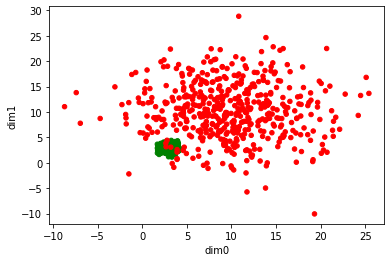

In [14]:
df_data_scenario_1.plot.scatter(x='dim0', y='dim1', c=df_data_scenario_1['label'])

In [15]:
n_train = 400
x_train = x[:n_train]
y_train = y[:n_train]
x_test = x[n_train:]
y_test = y[n_train:]

In [16]:
dataset_train = TwoSampleDataSet(x_train, y_train, device_obj=device_obj)
dataset_val = TwoSampleDataSet(x_test, y_test, device_obj=device_obj)

mmd_estimator = MMD(kernels_torch.BasicRBFKernelFunction(device_obj=device_obj, opt_sigma=False), device_obj=device_obj)
trainer = ModelTrainerTorchBackend(mmd_estimator, device_obj=device_obj)
trained_obj = trainer.train(dataset_training=dataset_train, dataset_validation=dataset_val, num_epochs=N_EPOCHS, batchsize=200, is_training_auto_stop=True, auto_stop_epochs=10)

2021-09-30 23:56:20,834 - model_criticism_mmd.logger_unit - INFO - Getting median initial sigma value...
2021-09-30 23:56:20,878 - model_criticism_mmd.logger_unit - INFO - initial by median-heuristics 1.93 with is_log=True
2021-09-30 23:56:20,880 - model_criticism_mmd.logger_unit - INFO - SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: True
    weight_decay: 0
)
2021-09-30 23:56:20,882 - model_criticism_mmd.logger_unit - INFO - Using ReduceLROnPlateau scheduler
2021-09-30 23:56:20,891 - model_criticism_mmd.logger_unit - INFO - Validation at 0. MMD^2 = 0.37445650919093176, ratio = [10.21178896] obj = [-2.32354283]
2021-09-30 23:56:21,063 - model_criticism_mmd.logger_unit - INFO -      5: [avg train] MMD^2 0.468167319322064 obj [-2.79866849] val-MMD^2 0.5867361852811441 val-ratio [12.26430434] val-obj [-2.50669296]  elapsed: 0.0
2021-09-30 23:56:21,725 - model_criticism_mmd.logger_unit - INFO -     25: [avg train] MMD^2 0.9303509484650998 obj [-3.390

In [17]:
trained_params = trained_obj.kernel_function_obj.get_params()
print(f'Preffered parameters scales = {trained_obj.scales} / {trained_params}')
mmd2, ratio = trainer.mmd_distance(x_test, y_test)
print(f'MMD^2 distance = {mmd2}')

Preffered parameters scales = [4.318114 3.565115] / {'log_sigma': tensor(1.9313, device='cuda:0', dtype=torch.float64)}
MMD^2 distance = 0.8547061368559242


# Kernel functions

You can set kernel functions as you like. The Kernel functions are in `model_criticism_mmd.backends.kernels_torch`

In [18]:
# example with Matern Kernel
from model_criticism_mmd.backends import kernels_torch
kernel_matern = kernels_torch.MaternKernelFunction(device_obj=device_obj, nu=0.5)
mmd_estimator_matern = MMD(kernel_matern, device_obj=device_obj)
trainer_matern = ModelTrainerTorchBackend(mmd_estimator_matern, device_obj=device_obj)
dataset_train = TwoSampleDataSet(x_train, y_train, device_obj)
dataset_val = TwoSampleDataSet(x_test, y_test, device_obj)
trained_obj_matern = trainer_matern.train(dataset_training=dataset_train, dataset_validation=dataset_val, 
                                          num_epochs=N_EPOCHS, batchsize=200, is_training_auto_stop=True, auto_stop_epochs=10)

2021-09-30 23:56:29,726 - model_criticism_mmd.logger_unit - INFO - Getting median initial sigma value...
2021-09-30 23:56:29,770 - model_criticism_mmd.logger_unit - INFO - initial by median-heuristics 5.8 with is_log=False
2021-09-30 23:56:29,774 - model_criticism_mmd.logger_unit - INFO - SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: True
    weight_decay: 0
)
2021-09-30 23:56:29,775 - model_criticism_mmd.logger_unit - INFO - Using ReduceLROnPlateau scheduler
2021-09-30 23:56:29,799 - model_criticism_mmd.logger_unit - INFO - Validation at 0. MMD^2 = 0.5491512331788676, ratio = [16.15197682] obj = [-2.78204245]
2021-09-30 23:56:30,072 - model_criticism_mmd.logger_unit - INFO -      5: [avg train] MMD^2 0.5811664099879351 obj [-3.26199539] val-MMD^2 0.6479490786740708 val-ratio [17.70129417] val-obj [-2.87363775]  elapsed: 0.0
2021-09-30 23:56:31,228 - model_criticism_mmd.logger_unit - INFO -     25: [avg train] MMD^2 0.7447823121371001 obj [-3.562

In [19]:
trained_obj_matern.scales

array([2.9777052, 2.5951946], dtype=float32)

As you see, the scales are totally different from the one with RBFKernel

## Kernel selection by test-power

In [20]:
from model_criticism_mmd import SelectionKernels
from model_criticism_mmd.backends.kernels_torch import BasicRBFKernelFunction, MaternKernelFunction
# scales can be None. In the case, the scales vector is initialized with 1.0 values.
scales = torch.tensor([0.05, 0.05])
kernels = [(scales, BasicRBFKernelFunction(device_obj=device_obj)),
           (scales, MaternKernelFunction(nu=0.5, device_obj=device_obj)),
          (scales, MaternKernelFunction(nu=1.5, device_obj=device_obj)),
          (scales, MaternKernelFunction(nu=2.5, device_obj=device_obj))]
# if is_training=True, the SelectionKernels class runs optimizations during selections.
selection_obj = SelectionKernels(candidate_kernels=kernels, dataset_validation=dataset_val, dataset_training=dataset_train, is_training=True)
result_select = selection_obj.run_selection(is_training_auto_stop=True, auto_stop_epochs=10)

2021-09-30 23:56:42,347 - model_criticism_mmd.logger_unit - INFO - Set the initial scales value
/home/kensuke-mi/Projects/eurocom/phd_projects/model_criticism_mmd/model_criticism_mmd/backends/backend_torch.py:271: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scales = torch.tensor(init_scale.clone().detach().cpu(), requires_grad=True, device=self.device_obj)
2021-09-30 23:56:42,348 - model_criticism_mmd.logger_unit - INFO - Getting median initial sigma value...
2021-09-30 23:56:42,394 - model_criticism_mmd.logger_unit - INFO - initial by median-heuristics 1.93 with is_log=True
2021-09-30 23:56:42,396 - model_criticism_mmd.logger_unit - INFO - SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: True
    weight_decay: 0
)
2021-09-30 23:56:42,397 - model_criticism_mmd.logger_unit - INFO - Using ReduceLROnP

The return object is a sorted list of tuples. The tuple has `(kernel-object, test-power)`.

In [21]:
result_select

[Kernel-type: <model_criticism_mmd.backends.kernels_torch.rbf_kernel.BasicRBFKernelFunction object at 0x7fb1eea3dc18>. Test-power: 29.109327867419236,
 Kernel-type: <model_criticism_mmd.backends.kernels_torch.matern_kernel.MaternKernelFunction object at 0x7fb1eea3ddd8>. Test-power: 28.604412377438727,
 Kernel-type: <model_criticism_mmd.backends.kernels_torch.matern_kernel.MaternKernelFunction object at 0x7fb1eea3dc88>. Test-power: 28.250597676803782,
 Kernel-type: <model_criticism_mmd.backends.kernels_torch.matern_kernel.MaternKernelFunction object at 0x7fb1eea3dcf8>. Test-power: 27.146648107358796]

# ARD weight

As you see in data generation, the data has huge variance only on __the 1st dimension__.

Then, the ARD weight has the highest value on the 1st dimension.

Remebmer that you set __opt_sigma = False__ when you need ARD weights.

In [22]:
import numpy
size = 100
n_epoch = N_EPOCHS
batch_size = 200

x_1st_dim = numpy.random.normal(loc=1.0, scale=0.0, size=size)
y_1st_dim = numpy.random.normal(loc=1.0, scale=50.0, size=size)

x_2_and_3_dim = numpy.random.normal(loc=10.0, scale=0.2, size=(size, 2))
y_2_and_3_dim = numpy.random.normal(loc=10.0, scale=0.2, size=(size, 2))

x = numpy.concatenate([numpy.reshape(x_1st_dim, (size, 1)), x_2_and_3_dim], axis=1)
y = numpy.concatenate([numpy.reshape(y_1st_dim, (size, 1)), y_2_and_3_dim], axis=1)

x_train = x[:80]
y_train = y[:80]
x_val = x[80:]
y_val = y[80:]

In [23]:
for n_dim in [0, 1, 2]:
    print(f'{n_dim+1} dim. mean(x)={x[:,n_dim].mean()} mean(y)={y[:,n_dim].mean()} var(x)={x[:,n_dim].var()} var(y)={y[:,n_dim].var()}')
# end for
dim_most_diff_varianace: int = sorted([(n_dim, abs(x[:,n_dim].var() - y[:,n_dim].var())) for n_dim in [0, 1, 2]],
                                      key=lambda t: t[1], reverse=True)[0][0]

1 dim. mean(x)=1.0 mean(y)=0.8056125593015441 var(x)=0.0 var(y)=3046.396274530907
2 dim. mean(x)=9.99124265861074 mean(y)=10.024162701650619 var(x)=0.03603354049834891 var(y)=0.04384882552156617
3 dim. mean(x)=9.983243688701092 mean(y)=9.979841256235177 var(x)=0.03852195580232908 var(y)=0.039652371337704405


In [24]:
dataset_train = TwoSampleDataSet(x_train, y_train, device_obj=device_obj)
dataset_val = TwoSampleDataSet(x_val, y_val, device_obj=device_obj)

mmd_estimator = MMD(kernels_torch.BasicRBFKernelFunction(device_obj=device_obj, opt_sigma=False), device_obj=device_obj)
trainer = ModelTrainerTorchBackend(mmd_estimator, device_obj=device_obj)
trained_obj = trainer.train(dataset_training=dataset_train, dataset_validation=dataset_val, num_epochs=N_EPOCHS, batchsize=200)

2021-09-30 23:58:11,986 - model_criticism_mmd.logger_unit - INFO - Getting median initial sigma value...
2021-09-30 23:58:11,990 - model_criticism_mmd.logger_unit - INFO - initial by median-heuristics 3.21 with is_log=True
2021-09-30 23:58:11,992 - model_criticism_mmd.logger_unit - INFO - SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: True
    weight_decay: 0
)
2021-09-30 23:58:11,994 - model_criticism_mmd.logger_unit - INFO - Using ReduceLROnPlateau scheduler
2021-09-30 23:58:11,999 - model_criticism_mmd.logger_unit - INFO - Validation at 0. MMD^2 = 0.007592659870002683, ratio = [75.9265987] obj = [-4.32976707]
2021-09-30 23:58:12,086 - model_criticism_mmd.logger_unit - INFO -      5: [avg train] MMD^2 0.4356114000515827 obj [-1.99280844] val-MMD^2 0.2017742591421663 val-ratio [3.35269829] val-obj [-1.20976548]  elapsed: 0.0
2021-09-30 23:58:12,511 - model_criticism_mmd.logger_unit - INFO -     25: [avg train] MMD^2 0.7580606284246869 obj [-2.453

In [25]:
assert np.argmax(trained_obj.scales) == dim_most_diff_varianace
trained_obj.scales

array([1.8077677, 0.3788385, 0.4461891], dtype=float32)

As you see, the TwoSampleDataSetex of max(scales) is same as the index that data has the highest variance.